In [2]:
import datetime 
from dateutil.relativedelta import *
import os
import re 
import string
import nltk
import pandas as pd 
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

import matplotlib.pyplot as plt 

from collections import OrderedDict
import langdetect 
from langdetect import DetectorFactory , detect_langs # for dermining language  
DetectorFactory.seed = 0

from google_trans_new import google_translator  # translating words
translator = google_translator()  

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud 
%matplotlib inline

ModuleNotFoundError: No module named 'langdetect'

In [3]:
'''Utility Functions'''
def concat_all_dataframes():
    ''' 
    Here we are going to combine all of the training csv's
    Into 1 dataframe that we can use for preprocessing
    
    adjust the path to whereever you are holding the data
    '''
    path = os.path.join(os.getcwd(),'google_scraping','data')
    csvs = os.listdir(path)
    output = pd.DataFrame()
    
    count = 0
    for csv in csvs:
        temp = pd.read_csv(os.path.join(path,csv))
        count += 1 
        
        if output.empty:
            output = temp        
        else:
            output = pd.concat([output,temp],axis=0)

    output.reset_index(inplace=True)        
    return output

def clean_translated_reviews(review):
    if 'Google' in review:
        res = review.split('(Original)')[0][23:]
        return res
    else:
        return review

def preprocessing_text(df):
    '''
    Here we are going to clean the text to be in a good format for further analysis 
    
    input: df ; DataFrame object that contains all of the reviews. 
    '''  
    lemm = WordNetLemmatizer()
    df = df.loc[~df.caption.isnull()] # here we are going to only process reviews 
    
    df.caption =  df.caption.apply(lambda review: clean_translated_reviews(review) if 'Google' in review else review)
        
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(str.lower)
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub(r'[^\w\s]','',review)) # removes punctuation
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub('\([^()]*\)','',review)) # removes words within parenthesis 
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: emoji_pattern.sub(r'', review)) 
    df.loc[:,'caption_split'] = df.loc[:,'caption'].apply(lambda review: review.split(' '))
    
    clean_reviews = []
    for review_idx , review in df.caption_split.items():
        for idx, word in enumerate(review):
            if word in stop_words:
                continue
            else:
                review[idx] = lemm.lemmatize(word)
        
        review_  = ' '.join(review)
        clean_reviews.append(review_)
    
    df.loc[:,'caption'] = clean_reviews
    df.drop(['index'],axis=1,inplace=True)
    
    
    
    return df


def rating_by_loc(df):
    # here we are going to return the locations that the 
    temp = pd.DataFrame(df.groupby(['address']).rating.value_counts(normalize=True)).sort_index(ascending=True).unstack()
    temp.fillna(0,inplace=True)
    output = {}
    for row in temp.iterrows():
        output[row[0]] = row[1]['rating']
    
    return output
        
def plot_rating_by_loc(d,key):
    # given a key, we are going to be able to plot the rating distribution for that location.
    # the format of the key is 
    d[key].plot(kind='bar');
    plt.title(f'Distribution of ratings from BJs {key} Google Reviews');
    plt.xlabel('rating score');
    plt.xticks(rotation=0)
    plt.ylabel('percent');
    
 
    
def create_language_col(df):
    # Here are we going to make a column of the language of the name
    df['language'] = None 
    for row in df.iterrows():
#         print(row[0])
        if (row[0] in [150,415,987,1120,9780,28028,32711]):
            df.loc[row[0],'language'] = 'en'
        else:
            
            lang = detect_langs(row[1]['caption'].split('(Original) ')[-1]).pop().__repr__()[:2]
            df.loc[row[0],'language'] = lang

    return df


def creating_word_clouds(n_grams_from_reviews,review_score):
    d_n_grams = {gram:freq for gram,freq in zip(n_grams_from_reviews['n-gram'],n_grams_from_reviews['value_count'])}
    plt.figure(figsize=(10,8))
    wordcloud = WordCloud(width=1600, height=800,stopwords=stopwords, background_color="white").generate_from_frequencies(d_n_grams)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(f'wordcloud{review_score}.png', facecolor='k', bbox_inches='tight')

    
def convert_relative_to_datetime(df):
    ''' Here we are going to convert relative dates given from google into estimated dates
    
    Input:
        df: The dataframe that is going to contain the relative and retrieval dates
    '''
    for idx , row in df.iterrows():
        print(idx)
        date_scraped = datetime.datetime.strptime(df.loc[idx,'retrieval_date'][:10],'%Y-%m-%d')
        
        relative_date = df.loc[idx,'relative_date'].split()

        if 'hour' in relative_date[1]:
                if relative_date[1] == 'hour':
                    res = date_scraped - relativedelta(hours=1)
                else:
                    res = date_scraped - relativedelta(hours=int(relative_date[0]))
                    
        if 'day' in relative_date[1]:
                if relative_date[1] == 'day':
                    res = date_scraped - relativedelta(days=1)
                else:
                    res = date_scraped - relativedelta(days=int(relative_date[0]))
                    
        if 'week' in relative_date[1]:
                if relative_date[1] == 'week':
                    res = date_scraped - relativedelta(weeks=1)
                else:
                    res = date_scraped - relativedelta(weeks=int(relative_date[0]))
                    
        if 'month' in relative_date[1]:
                if relative_date[1] == 'month':
                    res = date_scraped - relativedelta(months=1)
                else:
                    res = date_scraped - relativedelta(months=int(relative_date[0]))
        elif 'year' in relative_date[1]:
            if relative_date[1] == 'year':
                res = date_scraped - relativedelta(years=1)
            else:
                res = date_scraped - relativedelta(years=int(relative_date[0]))

        df.loc[idx,'relative_date'] = res
        
    return df 


def save_ppl_data(df):
    
    res = df[['relative_date','username','address']]
    res.to_csv('data_for_george.csv')

### Here we are going to change the relative date to datetime objects

In [86]:
test = convert_relative_to_datetime(test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Here we are going to save the relevant data to give to George to see if he can get the 

In [91]:
save_ppl_data(test)

In [89]:
test

,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address
0,0,ChZDSUhNMG9nS0VJQ0FnSUNLN2ZuQkpnEAE,Dirty store and pricing always wrong better of...,2021-04-15 00:00:00,2021-04-22 20:18:01.103344,1.0,C B,5,0,https://www.google.com/maps/contrib/1072936681...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
1,1,ChZDSUhNMG9nS0VJQ0FnSUNLMlpybVdBEAE,NaN,2021-04-15 00:00:00,2021-04-22 20:18:01.106339,5.0,Sylvia Granados,0,0,https://www.google.com/maps/contrib/1159908487...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
2,2,ChZDSUhNMG9nS0VJQ0FnSUNLeEstWEd3EAE,"I have been calling for an entire hour , no on...",2021-04-01 00:00:00,2021-04-22 20:18:01.108339,1.0,Zelda Ashby,3,0,https://www.google.com/maps/contrib/1009867597...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
3,3,ChdDSUhNMG9nS0VJQ0FnSUR5NjQ3Yi13RRAB,I usually go to the big one in Farmingdale to ...,2021-03-22 00:00:00,2021-04-22 20:18:01.109416,5.0,Arlene Giese,0,0,https://www.google.com/maps/contrib/1160215690...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
4,4,ChZDSUhNMG9nS0VJQ0FnSUN5MnAzdlN3EAE,NaN,2021-02-22 00:00:00,2021-04-22 20:18:01.111389,5.0,Kimberly Podina,0,0,https://www.google.com/maps/contrib/1161207552...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
...,...,...,...,...,...,...,...,...,...,...,...,...
44285,42,ChZDSUhNMG9nS0VJQ0FnSURjbk9URkpREAE,"You have more grocery variety, a deli, and fr...",2020-06-23 00:00:00,2021-04-23 09:11:18.071142,5.0,Leslie DeDona,0,0,https://www.google.com/maps/contrib/1017503560...,https://www.google.com/maps/place/BJ's+Wholesa...,"45101 Towne Center Blvd, New Baltimore, MI 48047"
44286,43,ChZDSUhNMG9nS0VJQ0FnSURjcEtLb0tREAE,The off I e that is supposed to sign u up is. ...,2020-06-23 00:00:00,2021-04-23 09:11:18.074141,1.0,Denise Garrison,0,0,https://www.google.com/maps/contrib/1161400734...,https://www.google.com/maps/place/BJ's+Wholesa...,"45101 Towne Center Blvd, New Baltimore, MI 48047"
44287,44,ChdDSUhNMG9nS0VJQ0FnSURjb0pMSXpBRRAB,NaN,2020-05-23 00:00:00,2021-04-23 09:11:18.077141,1.0,Jesus H,3,0,https://www.google.com/maps/contrib/1049778958...,https://www.google.com/maps/place/BJ's+Wholesa...,"45101 Towne Center Blvd, New Baltimore, MI 48047"
44288,45,ChZDSUhNMG9nS0VJQ0FnSUNjd2VQT1VBEAE,NaN,2020-04-23 00:00:00,2021-04-23 09:11:18.079142,5.0,Linnea Hadden,0,0,https://www.google.com/maps/contrib/1182222678...,https://www.google.com/maps/place/BJ's+Wholesa...,"45101 Towne Center Blvd, New Baltimore, MI 48047"


### Overall dataset: 44,820 rows of data

### Number of reviews with written text: 22,514

In [4]:
test = concat_all_dataframes()
processed_reviews = preprocessing_text(test)

C:\Users\Tiam Moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Tiam Moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\Tiam Moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [4]:
test.head()

,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address
0,0,ChZDSUhNMG9nS0VJQ0FnSUNLN2ZuQkpnEAE,Dirty store and pricing always wrong better of...,a week ago,2021-04-22 20:18:01.103344,1.0,C B,5,0,https://www.google.com/maps/contrib/1072936681...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
1,1,ChZDSUhNMG9nS0VJQ0FnSUNLMlpybVdBEAE,NaN,a week ago,2021-04-22 20:18:01.106339,5.0,Sylvia Granados,0,0,https://www.google.com/maps/contrib/1159908487...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
2,2,ChZDSUhNMG9nS0VJQ0FnSUNLeEstWEd3EAE,"I have been calling for an entire hour , no on...",3 weeks ago,2021-04-22 20:18:01.108339,1.0,Zelda Ashby,3,0,https://www.google.com/maps/contrib/1009867597...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
3,3,ChdDSUhNMG9nS0VJQ0FnSUR5NjQ3Yi13RRAB,I usually go to the big one in Farmingdale to ...,a month ago,2021-04-22 20:18:01.109416,5.0,Arlene Giese,0,0,https://www.google.com/maps/contrib/1160215690...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"
4,4,ChZDSUhNMG9nS0VJQ0FnSUN5MnAzdlN3EAE,NaN,2 months ago,2021-04-22 20:18:01.111389,5.0,Kimberly Podina,0,0,https://www.google.com/maps/contrib/1161207552...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735"


In [8]:
test.relative_date.unique()

array(['a week ago', '3 weeks ago', 'a month ago', '2 months ago',
       '3 months ago', '5 months ago', '6 months ago', '7 months ago',
       '8 months ago', '9 months ago', '10 months ago', '11 months ago',
       'a year ago', '2 years ago', '3 years ago', '4 years ago',
       '5 years ago', '6 years ago', '8 years ago', '10 years ago',
       '4 hours ago', '2 weeks ago', '7 years ago', '4 weeks ago',
       '4 months ago', '9 years ago', '5 days ago', 'a day ago',
       '3 days ago', '6 days ago', '2 days ago', '8 hours ago',
       '12 hours ago', '11 hours ago', '3 hours ago', '4 days ago',
       '17 hours ago', '7 hours ago', '6 hours ago', '18 hours ago',
       '15 hours ago'], dtype=object)

### The distribution of ratings for BJs locations in general

In [6]:
test.rating.value_counts(normalize=True)

5.0    0.540438
4.0    0.241860
1.0    0.105825
3.0    0.077647
2.0    0.034229
Name: rating, dtype: float64

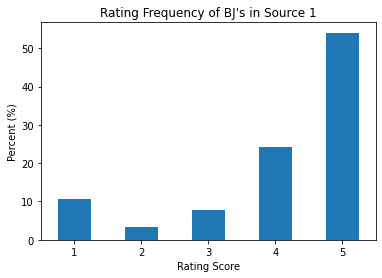

In [19]:
plot1 = test.rating.value_counts(normalize=True).sort_index()
plot1 = plot1 * 100

plot1.index = [1,2,3,4,5]
# test.rating.value_counts(normalize=True).sort_values(ascending=True).plot(kind='bar');
plot1.plot(kind='bar')
plt.title("Rating Frequency of BJ's in Source 1");
plt.xlabel('Rating Score');
plt.xticks(rotation=0)
plt.ylabel('Percent (%)');

### Distribution of rating scores by location

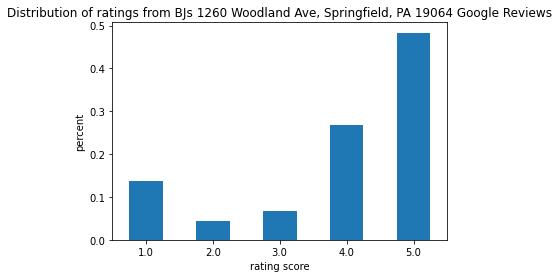

In [8]:
output = rating_by_loc(test)
plot_rating_by_loc(output,'1260 Woodland Ave, Springfield, PA 19064')

### Number of reviews that were translated: 1,284

### Here are locations with the most translated reviews.

In [11]:
x = test.loc[test.caption.str.contains('Google')==True,:]

In [35]:
x

,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address,language
35,35,ChZDSUhNMG9nS0VJQ0FnSUNzNDViS0tREAE,(Translated by Google) Exempt to make your pur...,a year ago,2021-04-22 20:18:49.811491,5.0,Joseph Ircanaupa,1,0,https://www.google.com/maps/contrib/1014793386...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",es
80,80,ChZDSUhNMG9nS0VJQ0FnSUN3Z3VDLUtREAE,(Translated by Google) MARK BONILLA (Original...,3 years ago,2021-04-22 20:20:52.154123,1.0,Auria Mendez,0,0,https://www.google.com/maps/contrib/1112336064...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",sw
88,88,ChdDSUhNMG9nS0VJQ0FnSURndTkzOHBRRRAB,(Translated by Google) Very good place (Origi...,3 years ago,2021-04-22 20:20:52.173120,4.0,Jonathan Martinez,0,0,https://www.google.com/maps/contrib/1151072699...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",tl
112,112,ChdDSUhNMG9nS0VJQ0FnSURnaE5icDFBRRAB,(Translated by Google) Everything is good in t...,3 years ago,2021-04-22 20:22:06.135729,5.0,Jesus Ulloa,10,0,https://www.google.com/maps/contrib/1066588255...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",es
130,130,ChdDSUhNMG9nS0VJQ0FnSUN3MU52emt3RRAB,(Translated by Google) Excellent place to buy ...,3 years ago,2021-04-22 20:22:55.614856,5.0,Rabi Lovos,0,0,https://www.google.com/maps/contrib/1170016781...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",ro
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43511,381,ChZDSUhNMG9nS0VJQ0FnSURVenJEQ1dBEAE,I went to Google and it stated that the Madiso...,a year ago,2021-04-23 09:57:13.627937,1.0,jeff george,17,0,https://www.google.com/maps/contrib/1131644700...,https://www.google.com/maps/place/BJ's+Wholesa...,"29101 John R Rd, Madison Heights, MI 48071",None
43573,58,ChdDSUhNMG9nS0VJQ0FnSUNjdGMyaXd3RRAB,(Translated by Google) I UNDERSTAND THAT THEY ...,a year ago,2021-04-23 10:00:10.174202,5.0,Luna Báez,7,0,https://www.google.com/maps/contrib/1111781428...,https://www.google.com/maps/place/BJ's+Wholesa...,"15523 Racho Rd, Taylor, MI 48180",None
43604,89,ChZDSUhNMG9nS0VJQ0FnSUNjMXRuV1dnEAE,(Translated by Google) The prices are good (O...,a year ago,2021-04-23 10:01:29.819425,5.0,Cosme Chapa,0,0,https://www.google.com/maps/contrib/1021504790...,https://www.google.com/maps/place/BJ's+Wholesa...,"15523 Racho Rd, Taylor, MI 48180",None
43609,94,ChZDSUhNMG9nS0VJQ0FnSUNNeXNLeGVBEAE,(Translated by Google) Love BJs (Original) Lo...,a year ago,2021-04-23 10:01:56.541052,5.0,KristiLuv,14,0,https://www.google.com/maps/contrib/1083872779...,https://www.google.com/maps/place/BJ's+Wholesa...,"15523 Racho Rd, Taylor, MI 48180",None


In [12]:
x.address.value_counts()[:10]

8005 NW 95th St, Hialeah, FL 33016            107
184 W 237th St, The Bronx, NY 10463            72
7007 SW 117th Ave, Miami, FL 33183             69
610 Exterior Street, The Bronx, NY 10451       61
17250 NW 57th Ave, Hialeah, FL 33015           56
10425 Marlin Rd, Cutler Bay, FL 33157          47
1752 Shore Pkwy, Brooklyn, NY 11214            47
131-07 40th Rd Ste. A100, Queens, NY 11354     41
16200 SW 88th St, Miami, FL 33196              34
1001 E Edgar Rd, Linden, NJ 07036              32
Name: address, dtype: int64

### Creating a language col to determine which languages are being spoken.

In [13]:
x = create_language_col(x)

c:\users\tiam moradi\anaconda3\envs\loseit\lib\site-packages\ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\tiam moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [14]:
x_no_english = x.loc[x.language !='en']
x_no_english

,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address,language
35,35,ChZDSUhNMG9nS0VJQ0FnSUNzNDViS0tREAE,(Translated by Google) Exempt to make your pur...,a year ago,2021-04-22 20:18:49.811491,5.0,Joseph Ircanaupa,1,0,https://www.google.com/maps/contrib/1014793386...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",es
80,80,ChZDSUhNMG9nS0VJQ0FnSUN3Z3VDLUtREAE,(Translated by Google) MARK BONILLA (Original...,3 years ago,2021-04-22 20:20:52.154123,1.0,Auria Mendez,0,0,https://www.google.com/maps/contrib/1112336064...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",sw
88,88,ChdDSUhNMG9nS0VJQ0FnSURndTkzOHBRRRAB,(Translated by Google) Very good place (Origi...,3 years ago,2021-04-22 20:20:52.173120,4.0,Jonathan Martinez,0,0,https://www.google.com/maps/contrib/1151072699...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",tl
112,112,ChdDSUhNMG9nS0VJQ0FnSURnaE5icDFBRRAB,(Translated by Google) Everything is good in t...,3 years ago,2021-04-22 20:22:06.135729,5.0,Jesus Ulloa,10,0,https://www.google.com/maps/contrib/1066588255...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",es
130,130,ChdDSUhNMG9nS0VJQ0FnSUN3MU52emt3RRAB,(Translated by Google) Excellent place to buy ...,3 years ago,2021-04-22 20:22:55.614856,5.0,Rabi Lovos,0,0,https://www.google.com/maps/contrib/1170016781...,https://www.google.com/maps/place/BJ's+Wholesa...,"50 Daniel St, Farmingdale, NY 11735",ro
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42669,163,ChZDSUhNMG9nS0VJQ0FnSUNBZ00yTGJnEAE,(Translated by Google) Very good it is a place...,3 years ago,2021-04-23 05:27:34.612662,5.0,Many Silverio,0,0,https://www.google.com/maps/contrib/1106482100...,https://www.google.com/maps/place/BJ's+Wholesa...,"4701 O'Donnell St, Baltimore, MD 21224",es
42788,28,ChdDSUhNMG9nS0VJQ0FnSUM4c0tPbDVBRRAB,(Translated by Google) love Bjs (Original) lo...,10 months ago,2021-04-23 05:33:16.305448,5.0,Sherry Lee,3,0,https://www.google.com/maps/contrib/1102573364...,https://www.google.com/maps/place/BJ's+Wholesa...,"1035 Jockey Ct, Summerville, SC 29483",sl
43604,89,ChZDSUhNMG9nS0VJQ0FnSUNjMXRuV1dnEAE,(Translated by Google) The prices are good (O...,a year ago,2021-04-23 10:01:29.819425,5.0,Cosme Chapa,0,0,https://www.google.com/maps/contrib/1021504790...,https://www.google.com/maps/place/BJ's+Wholesa...,"15523 Racho Rd, Taylor, MI 48180",es
43609,94,ChZDSUhNMG9nS0VJQ0FnSUNNeXNLeGVBEAE,(Translated by Google) Love BJs (Original) Lo...,a year ago,2021-04-23 10:01:56.541052,5.0,KristiLuv,14,0,https://www.google.com/maps/contrib/1083872779...,https://www.google.com/maps/place/BJ's+Wholesa...,"15523 Racho Rd, Taylor, MI 48180",sl


In [15]:
languages_10 = x_no_english.language.value_counts(normalize=True)[:10]
languages_10 *= 100
languages_10

es    67.990654
ca     5.841121
pt     4.127726
sl     2.725857
ro     2.492212
de     2.024922
it     1.713396
ru     1.246106
ko     1.246106
zh     1.168224
Name: language, dtype: float64

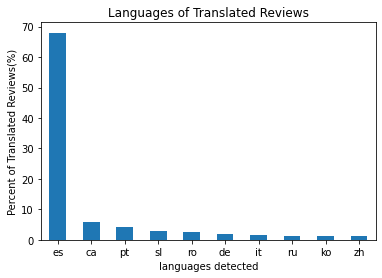

In [16]:
# spanish, Catalan,Portuguese,Slovenian,Romanian,Chinese(sino-tibetan),German,Italian,Arabic,Russian
languages_10.plot(kind='bar');
plt.title('Languages of Translated Reviews')
plt.xlabel('languages detected');
plt.ylabel('Percent of Translated Reviews(%)');
plt.xticks(rotation=0);

### Looking at 4 / 5 grams by rating of reviews to see if there are any unique phrases. (by ratings) 

In [25]:
# if not good, go back to 2-3
tfidf5 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf4 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf3 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf2 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf1 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')

#########################################################################
# This section is going to be for the Topic Modelling 
tfidf5_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf4_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf3_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf2_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf1_ = TfidfVectorizer(max_features=50,stop_words='english')

#### Here we are seperating the reviews based on the rating score

In [26]:
processed_reviews_five = processed_reviews.loc[processed_reviews.rating == 5,'caption']
processed_reviews_four = processed_reviews.loc[processed_reviews.rating == 4,'caption']
processed_reviews_three = processed_reviews.loc[processed_reviews.rating == 3,'caption']
processed_reviews_two = processed_reviews.loc[processed_reviews.rating == 2,'caption']
processed_reviews_one = processed_reviews.loc[processed_reviews.rating == 1,'caption']

#### Here we are getting different Tf-Idf Matricies for each group

In [27]:
tfidf_five_star = tfidf5.fit_transform(processed_reviews_five)
tfidf_four_star = tfidf4.fit_transform(processed_reviews_four)
tfidf_three_star = tfidf3.fit_transform(processed_reviews_three)
tfidf_two_star = tfidf2.fit_transform(processed_reviews_two)
tfidf_one_star = tfidf1.fit_transform(processed_reviews_one)

#### Creating Document Term Matricies and n-grams for 5 star reviews

In [28]:
tfidf5_s = pd.Series(tfidf5.vocabulary_)
tfidf5_s=tfidf5_s.to_frame()
tfidf5_s['n-gram'] = tfidf5_s.index
tfidf5_s.index = range(len(tfidf5_s.index))
tfidf5_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams5 = tfidf5_s.loc[~tfidf5_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams5

,value_count,n-gram
31,49,store clean organized
32,48,staff friendly helpful
2,47,selection great price
20,46,selection good price
16,45,save lot money
12,44,sam club costco
21,43,product good price
15,42,place shop good
34,41,place shop bulk
43,40,place buy bulk


In [8]:
lda_rating_5 = tfidf5_.fit_transform(processed_reviews_five)
lda_rating_5_pd = pd.DataFrame(lda_rating_5.toarray(),columns=tfidf5_.get_feature_names())

NameError: name 'tfidf5_' is not defined

#### Creating Document Term Matricies and n-grams for 4 star reviews

In [30]:
tfidf4s = pd.Series(tfidf4.vocabulary_)
tfidf4s=tfidf4s.to_frame()
tfidf4s['n-gram'] = tfidf4s.index
tfidf4s.index = range(len(tfidf4s.index))
tfidf4s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams4= tfidf4s.loc[~tfidf4s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams4

,value_count,n-gram
21,49,wide variety product
0,48,typical big box
16,47,store great price
18,46,staff friendly helpful
41,45,self checkout lane
29,44,selection great price
46,43,selection good price
11,42,product great price
27,41,product good price
38,40,price good selection


In [31]:
lda_rating_4 = tfidf4_.fit_transform(processed_reviews_four)
lda_rating_4_pd = pd.DataFrame(lda_rating_4.toarray(),columns=tfidf4_.get_feature_names())

#### Creating Document Term Matricies and n-grams for 3 star reviews

In [32]:
tfidf3.vocabulary_

tfidf3_s = pd.Series(tfidf3.vocabulary_)
tfidf3_s=tfidf3_s.to_frame()
tfidf3_s['n-gram'] = tfidf3_s.index
tfidf3_s.index = range(len(tfidf3_s.index))
tfidf3_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams3 = tfidf3_s.loc[~tfidf3_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams3

,value_count,n-gram
34,49,wait 20 minute
38,48,typical wholesale club
6,47,store customer service
4,46,store clean staff
32,45,staff friendly helpful
20,44,slow customer service
30,43,self checkout line
3,42,self check line
8,41,sam club costco
39,40,price little high


In [33]:
lda_rating_3 = tfidf3_.fit_transform(processed_reviews_three)
lda_rating_3_pd = pd.DataFrame(lda_rating_3.toarray(),columns=tfidf3_.get_feature_names())

#### Creating Document Term Matricies and n-grams for 2 star reviews

In [58]:
tfidf2.vocabulary_

tfidf2_s = pd.Series(tfidf2.vocabulary_)
tfidf2_s=tfidf2_s.to_frame()
tfidf2_s['n-gram'] = tfidf2_s.index
tfidf2_s.index = range(len(tfidf2_s.index))
tfidf2_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams2 = tfidf2_s.loc[~tfidf2_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams2

,value_count,n-gram
13,49,worst customer service
40,48,wait long time
11,47,terrible customer service
12,46,store waste time
26,45,store clean organized
30,44,staff pick phone
42,43,shopping cart outside
41,42,shopping cart available
31,41,self check machine
46,40,self check line


In [35]:
lda_rating_2 = tfidf2_.fit_transform(processed_reviews_two)
lda_rating_2_pd = pd.DataFrame(lda_rating_2.toarray(),columns=tfidf2_.get_feature_names())

#### Creating Document Term Matricies and n-grams for 1 star reviews

In [36]:
tfidf1.vocabulary_
tfidf1_s = pd.Series(tfidf1.vocabulary_)
tfidf1_s=tfidf1_s.to_frame()
tfidf1_s['n-gram'] = tfidf1_s.index
tfidf1_s.index = range(len(tfidf1_s.index))
tfidf1_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams = tfidf1_s.loc[~tfidf1_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams

,value_count,n-gram
3,49,worst customer service
47,48,worst bjs ive
10,47,worse customer service
43,46,work customer service
15,45,went customer service
36,44,week half ago
35,43,waited 20 minute
0,42,time customer service
38,41,ticket actually given item ups
20,40,terrible customer service


In [37]:
lda_rating_1 = tfidf1_.fit_transform(processed_reviews_one)
lda_rating_1_pd = pd.DataFrame(lda_rating_1.toarray(),columns=tfidf1_.get_feature_names())

### Topic Modelling by ratings

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 3
model5 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model4 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model3 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model1 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [39]:
model5.fit(lda_rating_5_pd)
model4.fit(lda_rating_4_pd)
model3.fit(lda_rating_3_pd)
model2.fit(lda_rating_2_pd)
model1.fit(lda_rating_1_pd)

LatentDirichletAllocation(n_components=3, random_state=0)

In [40]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

### Topics for Model 5 

In [41]:
display_topics(model5,lda_rating_5_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,love,721.6,friendly,409.3,great,1266.1
1,good,719.1,nice,394.3,price,831.3
2,store,466.7,staff,387.1,place,741.1
3,clean,403.9,excellent,370.3,service,452.2
4,shopping,380.8,bjs,360.9,good,399.4
5,bjs,290.7,helpful,360.8,shop,393.1
6,coupon,281.7,need,351.4,selection,296.6
7,buy,235.1,best,314.2,deal,278.1
8,lot,220.9,like,277.4,item,270.3
9,food,212.5,gas,245.7,customer,223.2


### Topics for Model 4

In [42]:
display_topics(model4,lda_rating_4_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,good,547.1,bjs,277.0,place,232.9
1,price,409.0,great,193.7,clean,215.1
2,shopping,159.3,like,172.5,nice,194.3
3,selection,149.9,need,161.1,staff,167.4
4,love,144.6,store,142.7,friendly,154.2
5,product,142.1,line,133.4,service,152.8
6,coupon,140.7,time,129.8,shop,139.0
7,item,134.9,gas,125.6,helpful,130.9
8,thing,124.0,buy,107.4,deal,121.6
9,food,112.3,club,102.3,great,117.0


### Topics for Model 3

In [43]:
display_topics(model3,lda_rating_3_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,store,90.5,bjs,125.3,price,118.4
1,line,87.0,good,91.7,service,83.7
2,time,73.8,ok,67.7,customer,78.0
3,long,64.4,just,63.1,coupon,70.5
4,need,60.9,item,62.5,great,65.9
5,staff,53.2,membership,51.7,place,63.2
6,cashier,51.9,gas,51.0,good,62.7
7,better,49.3,lot,50.8,product,50.6
8,deli,44.5,location,50.3,selection,46.9
9,costco,44.5,shopping,48.6,like,38.0


### Topics for Model 2

In [44]:
display_topics(model2,lda_rating_2_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,store,74.0,cashier,46.6,service,76.3
1,bjs,69.0,price,44.6,customer,65.9
2,time,50.7,like,38.7,line,61.7
3,good,45.5,place,38.5,membership,45.1
4,coupon,44.1,just,37.8,long,45.1
5,employee,40.5,shopping,36.9,product,34.9
6,need,36.2,cart,35.0,staff,32.1
7,dont,35.6,checkout,31.7,deli,31.7
8,went,35.1,check,31.5,lot,30.8
9,costco,33.9,item,31.5,year,27.9


### Topics for Model 1

In [45]:
display_topics(model1,lda_rating_1_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,service,357.5,line,198.5,store,237.9
1,customer,335.2,tire,182.4,rude,177.0
2,worst,142.6,just,141.0,employee,166.6
3,bad,134.1,place,131.8,membership,147.3
4,check,122.6,bjs,123.4,item,136.1
5,horrible,112.8,people,123.3,dont,133.1
6,need,111.5,minute,122.1,manager,128.3
7,cashier,101.2,phone,121.9,location,126.4
8,experience,97.1,order,116.7,bjs,120.8
9,help,96.0,hour,106.7,time,109.9


## Creating word clouds for each rating group

### 5 star reviews 

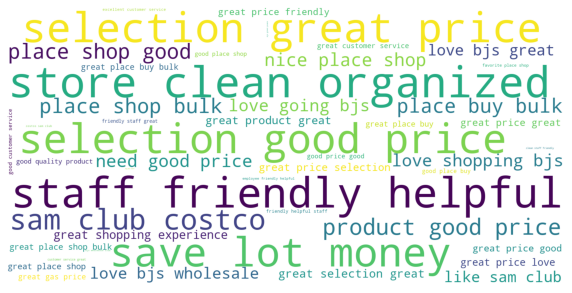

In [54]:
creating_word_clouds(top_n_grams5,5)

### 4 star reviews

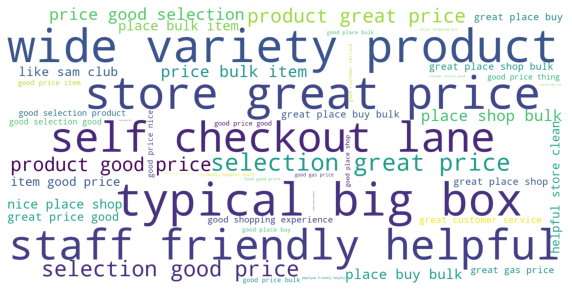

In [55]:
creating_word_clouds(top_n_grams4,4)

### 3 Star Reviews

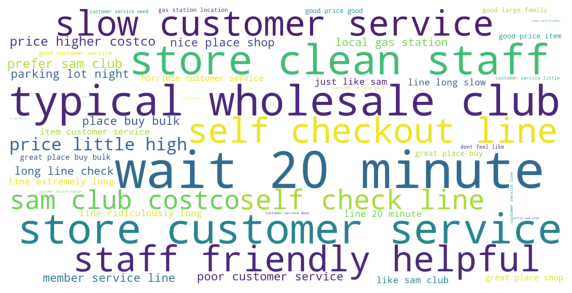

In [56]:
creating_word_clouds(top_n_grams3,3)

### 2 Star Reviews

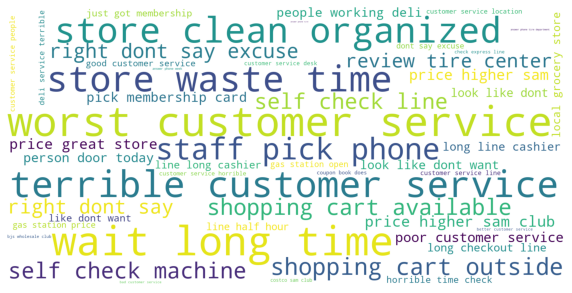

In [59]:
creating_word_clouds(top_n_grams2,2)

### 1 Star Review 

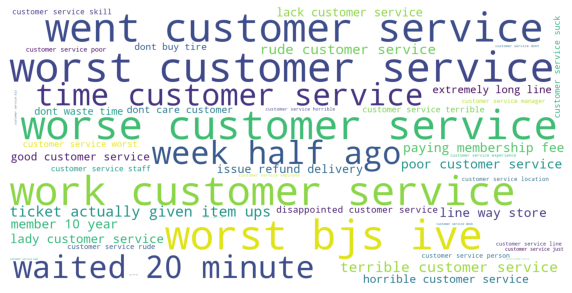

In [60]:
creating_word_clouds(top_n_grams,1)

## Takeaways per Rating ( Both N-grams and Topic Modelling ) 

### Reviews with 5 star ratings

- [x] staff being friendly / helpful
- [x] great place to buy in bulk
- [x] great customer service 
- [x] good prices

### Reviews with 4 star ratings

- [x] n-grams were very similar to 5 star ratings 


### Reviews with 3 star ratings
- [x] parking lot 
- [x] priced items were wrong 
- [x] long line 
- [x] costco better 
- [x] gas and possible relation to price


### Reviews with 2 star ratings 
- [x] terrible customer service
- [x] raised prices
- [x] question supervisor
- [x] gas prices
- [x] lack organic products
- [x] long checkout like
- [x] employee's or other staff being rude 

### Reviews with 1 star ratings 
- [x] worst/rude customer service
- [x] refuse issue / issue refund delivery ticket 
- [x] not renewing membership
- [x] things taking a long with delivery / online ordering 
- [x] don't buy tire 